# Untitled Gallstone Disease Prediction Notebook 

## Group Members 

- Augustus Clark Raphael P. Rodriguez
- James Angelo R. Dela Cruz
- Harry William R. Acosta II 
- Jasper Anthony G. Perillo

## Description 
This notebook entails the development and assessment of a selection of machine learning models to determine which performs the best under given testing conditions.


In [287]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scikit-learn imblearn shap

In [288]:
# Import core libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as display

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB # Removed due to low performance
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif

# XAI
import shap

### Load Dataset
Dataset has been converted from .xlsx to .csv for processing convenience.

In [289]:
# Load dataset
df = pd.read_csv('(CSV)dataset-uci.csv')

# Inspect dataset shape and columns
print(f'Dataset shape: {df.shape}')
print(f'Columns: {df.columns.tolist()}')

target_col = 'Gallstone Status'  # Target variable

Dataset shape: (319, 39)
Columns: ['Gallstone Status', 'Age', 'Gender', 'Comorbidity', 'Coronary Artery Disease (CAD)', 'Hypothyroidism', 'Hyperlipidemia', 'Diabetes Mellitus (DM)', 'Height', 'Weight', 'Body Mass Index (BMI)', 'Total Body Water (TBW)', 'Extracellular Water (ECW)', 'Intracellular Water (ICW)', 'Extracellular Fluid/Total Body Water (ECF/TBW)', 'Total Body Fat Ratio (TBFR) (%)', 'Lean Mass (LM) (%)', 'Body Protein Content (Protein) (%)', 'Visceral Fat Rating (VFR)', 'Bone Mass (BM)', 'Muscle Mass (MM)', 'Obesity (%)', 'Total Fat Content (TFC)', 'Visceral Fat Area (VFA)', 'Visceral Muscle Area (VMA) (Kg)', 'Hepatic Fat Accumulation (HFA)', 'Glucose', 'Total Cholesterol (TC)', 'Low Density Lipoprotein (LDL)', 'High Density Lipoprotein (HDL)', 'Triglyceride', 'Aspartat Aminotransferaz (AST)', 'Alanin Aminotransferaz (ALT)', 'Alkaline Phosphatase (ALP)', 'Creatinine', 'Glomerular Filtration Rate (GFR)', 'C-Reactive Protein (CRP)', 'Hemoglobin (HGB)', 'Vitamin D']


### Model Evaluation Method 
Defined model evaluation function to evaluate model performance, will be used later on.

In [290]:
def evaluate_model(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
    
    # Model Metrics
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if auc is not None:
        print(f"ROC AUC: {auc:.4f}")

### Cross-Validation Model Evaluation Method

In [291]:
def cross_val_evaluate(model, X, y, cv):
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"Mean Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

## EXPLORATORY DATA ANALYSIS
The EDA for this notebook contains the following: 

### Step 1: Verification of Missing values
Simple check of missing values for assurance even if dataset is said to be complete. 

In [292]:
# -------------------------------
missing_counts = df.isnull().sum()
print("Missing values per column:\n", missing_counts)

Missing values per column:
 Gallstone Status                                  0
Age                                               0
Gender                                            0
Comorbidity                                       0
Coronary Artery Disease (CAD)                     0
Hypothyroidism                                    0
Hyperlipidemia                                    0
Diabetes Mellitus (DM)                            0
Height                                            0
Weight                                            0
Body Mass Index (BMI)                             0
Total Body Water (TBW)                            0
Extracellular Water (ECW)                         0
Intracellular Water (ICW)                         0
Extracellular Fluid/Total Body Water (ECF/TBW)    0
Total Body Fat Ratio (TBFR) (%)                   0
Lean Mass (LM) (%)                                0
Body Protein Content (Protein) (%)                0
Visceral Fat Rating (VFR)           

### Step 2: Descriptive Statistics 

In [293]:
# -------------------------------
num_features = df.select_dtypes(include=np.number).columns.tolist()
num_features = [f for f in num_features if f != target_col]

print("\nDescriptive statistics for numerical features:")
display.display(df[num_features].describe())


Descriptive statistics for numerical features:


,Age,Gender,Comorbidity,Coronary Artery Disease (CAD),Hypothyroidism,Hyperlipidemia,Diabetes Mellitus (DM),Height,Weight,Body Mass Index (BMI),...,High Density Lipoprotein (HDL),Triglyceride,Aspartat Aminotransferaz (AST),Alanin Aminotransferaz (ALT),Alkaline Phosphatase (ALP),Creatinine,Glomerular Filtration Rate (GFR),C-Reactive Protein (CRP),Hemoglobin (HGB),Vitamin D
count,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.00000,319.000000,319.000000,...,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,48.068966,0.492163,0.335423,0.037618,0.028213,0.025078,0.134796,167.15674,80.564890,28.877116,...,49.475549,144.502163,21.684953,26.855799,73.112539,0.800611,100.818903,1.853856,14.418182,21.401411
std,12.114558,0.500724,0.517340,0.190568,0.165841,0.156609,0.342042,10.05303,15.709069,5.313707,...,17.718701,97.904493,16.697605,27.884413,24.181069,0.176433,16.971396,4.989591,1.775815,9.981659
min,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,145.00000,42.900000,17.400000,...,25.000000,1.390000,8.000000,3.000000,7.000000,0.460000,10.600000,0.000000,8.500000,3.500000
25%,38.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,159.50000,69.600000,25.250000,...,40.000000,83.000000,15.000000,14.250000,58.000000,0.650000,94.170000,0.000000,13.300000,13.250000
50%,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,168.00000,78.800000,28.300000,...,46.500000,119.000000,18.000000,19.000000,71.000000,0.790000,104.000000,0.215000,14.400000,22.000000
75%,56.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,175.00000,91.250000,31.850000,...,56.000000,172.000000,23.000000,30.000000,86.000000,0.920000,110.745000,1.615000,15.700000,28.060000
max,96.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,191.00000,143.500000,49.700000,...,273.000000,838.000000,195.000000,372.000000,197.000000,1.460000,132.000000,43.400000,18.800000,53.100000


### Step 3: Numerical Feature Distribution 

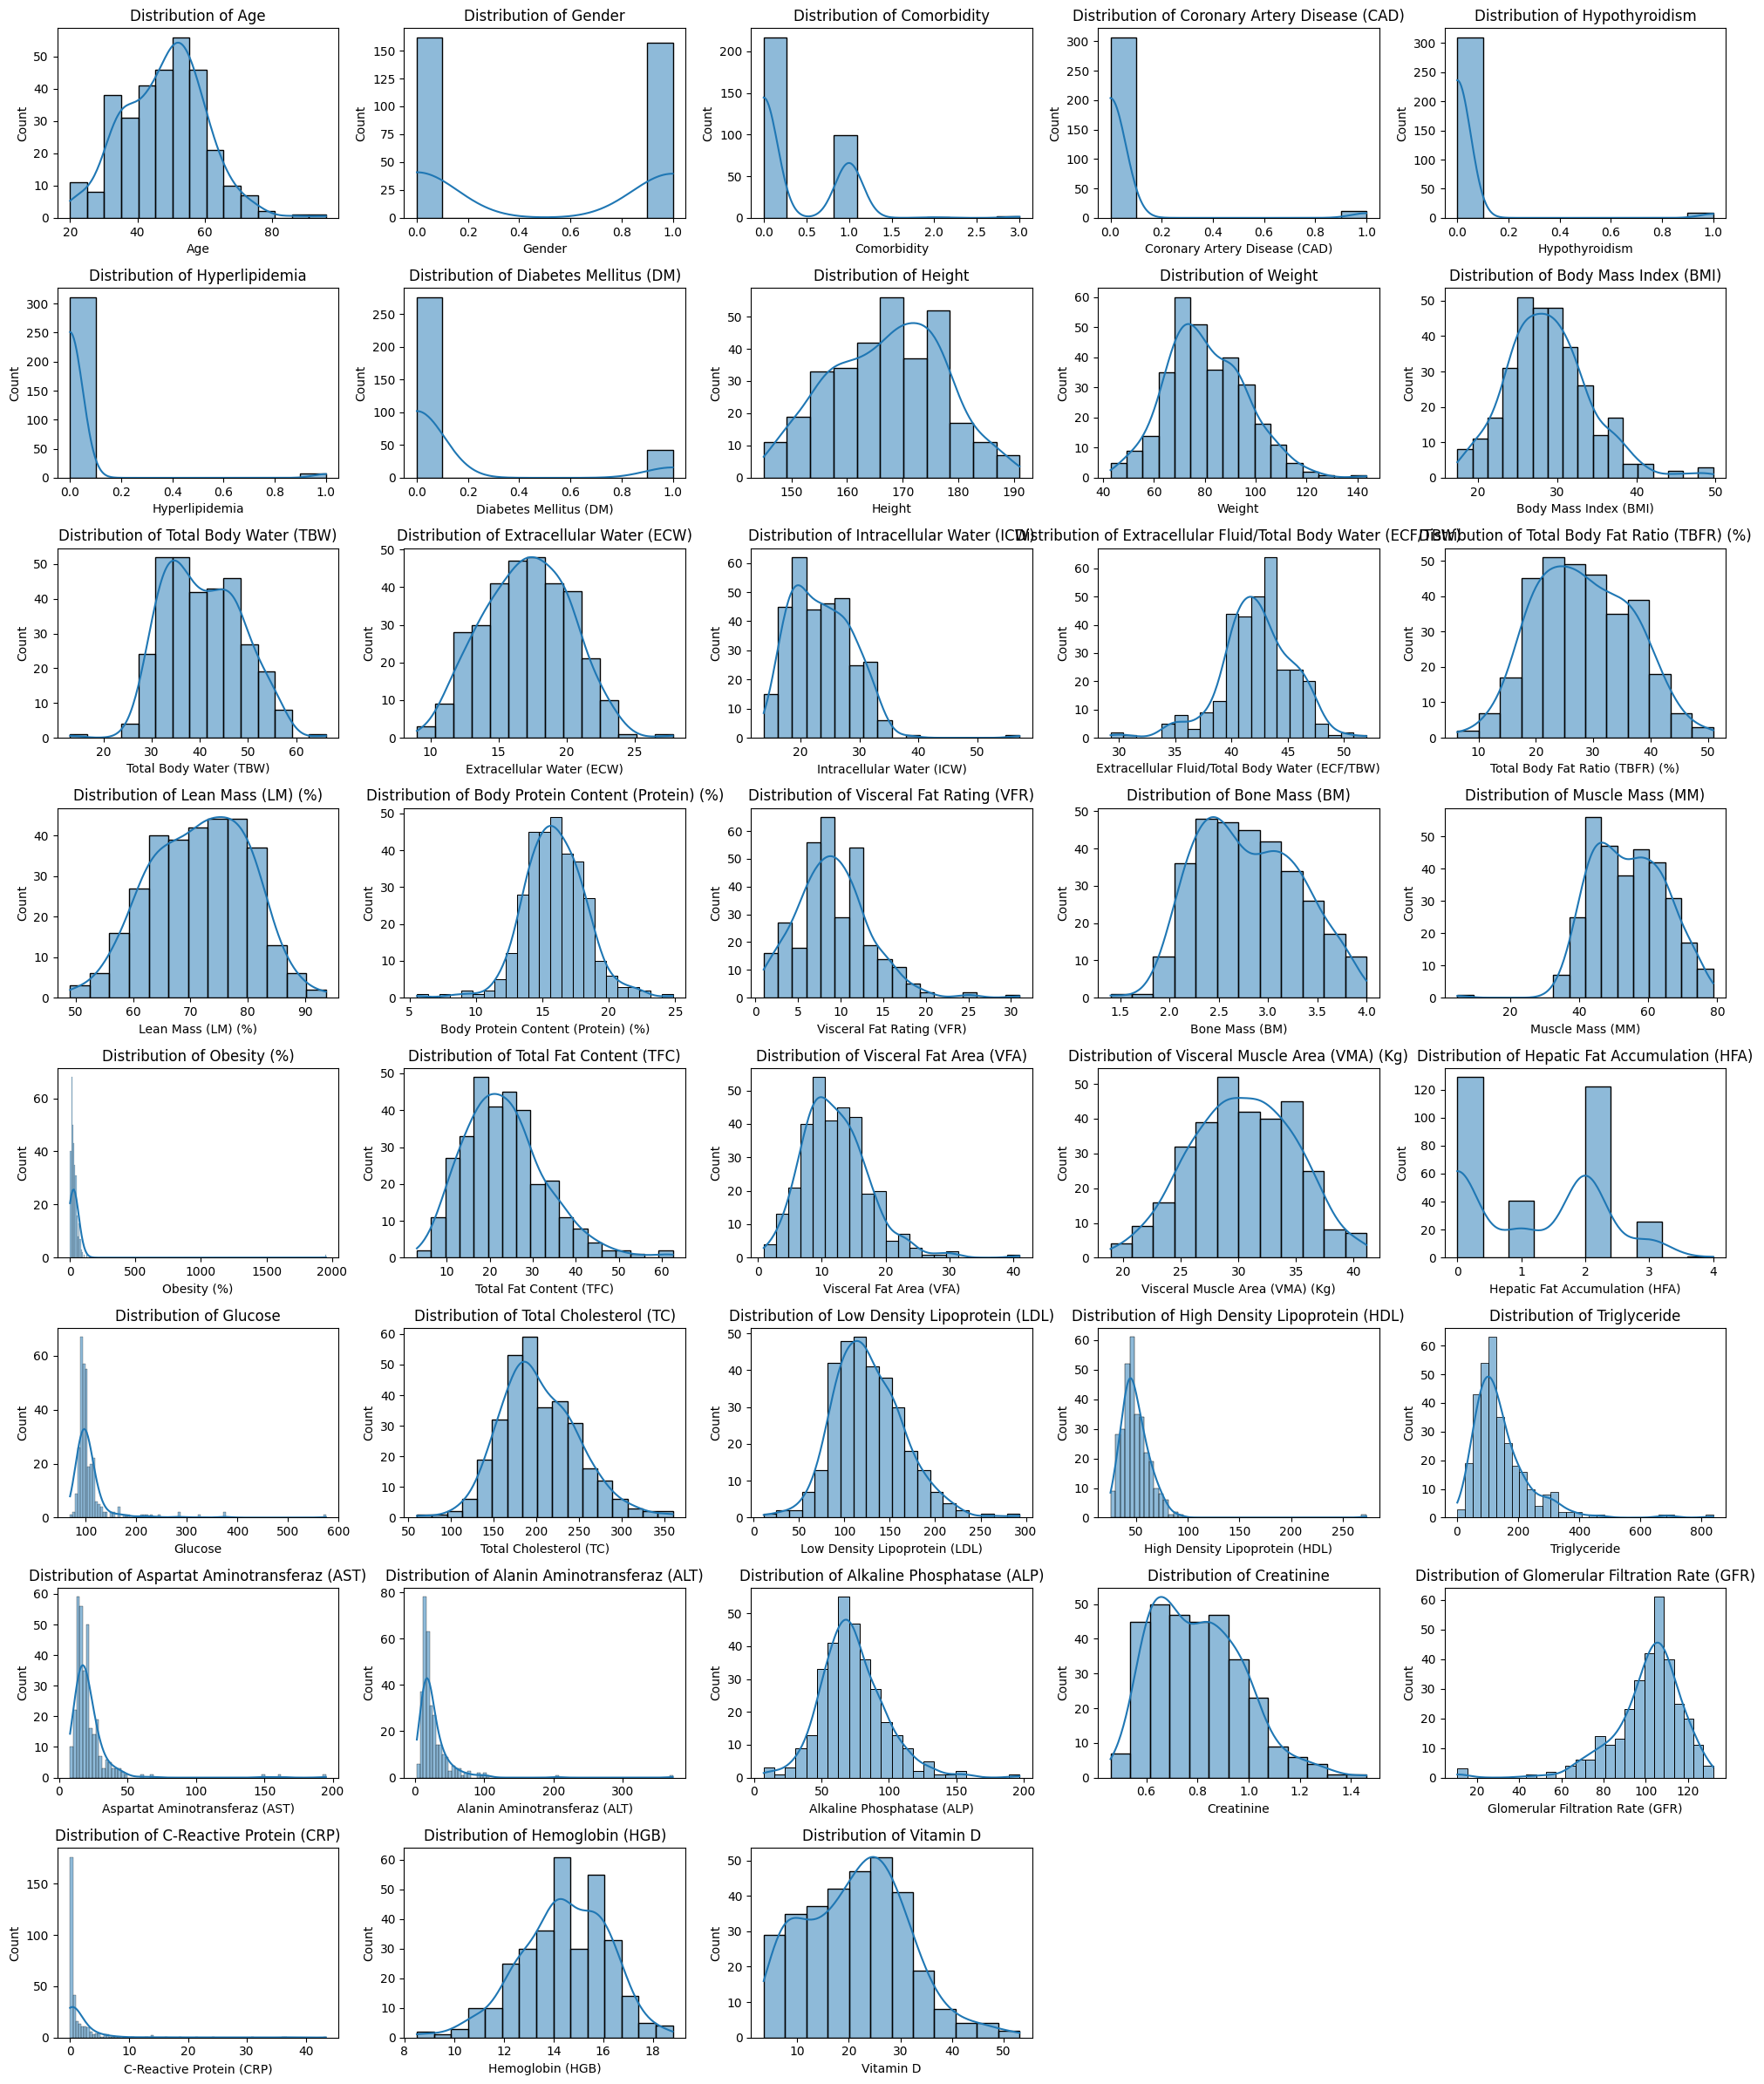

In [294]:
num_plots = len(num_features)
cols = 5  # or any number you prefer
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(cols * 4, rows * 3))  # Adjust figsize accordingly

for i, col in enumerate(num_features, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

### Step 4: Boxplots to check for outliers in numerical features

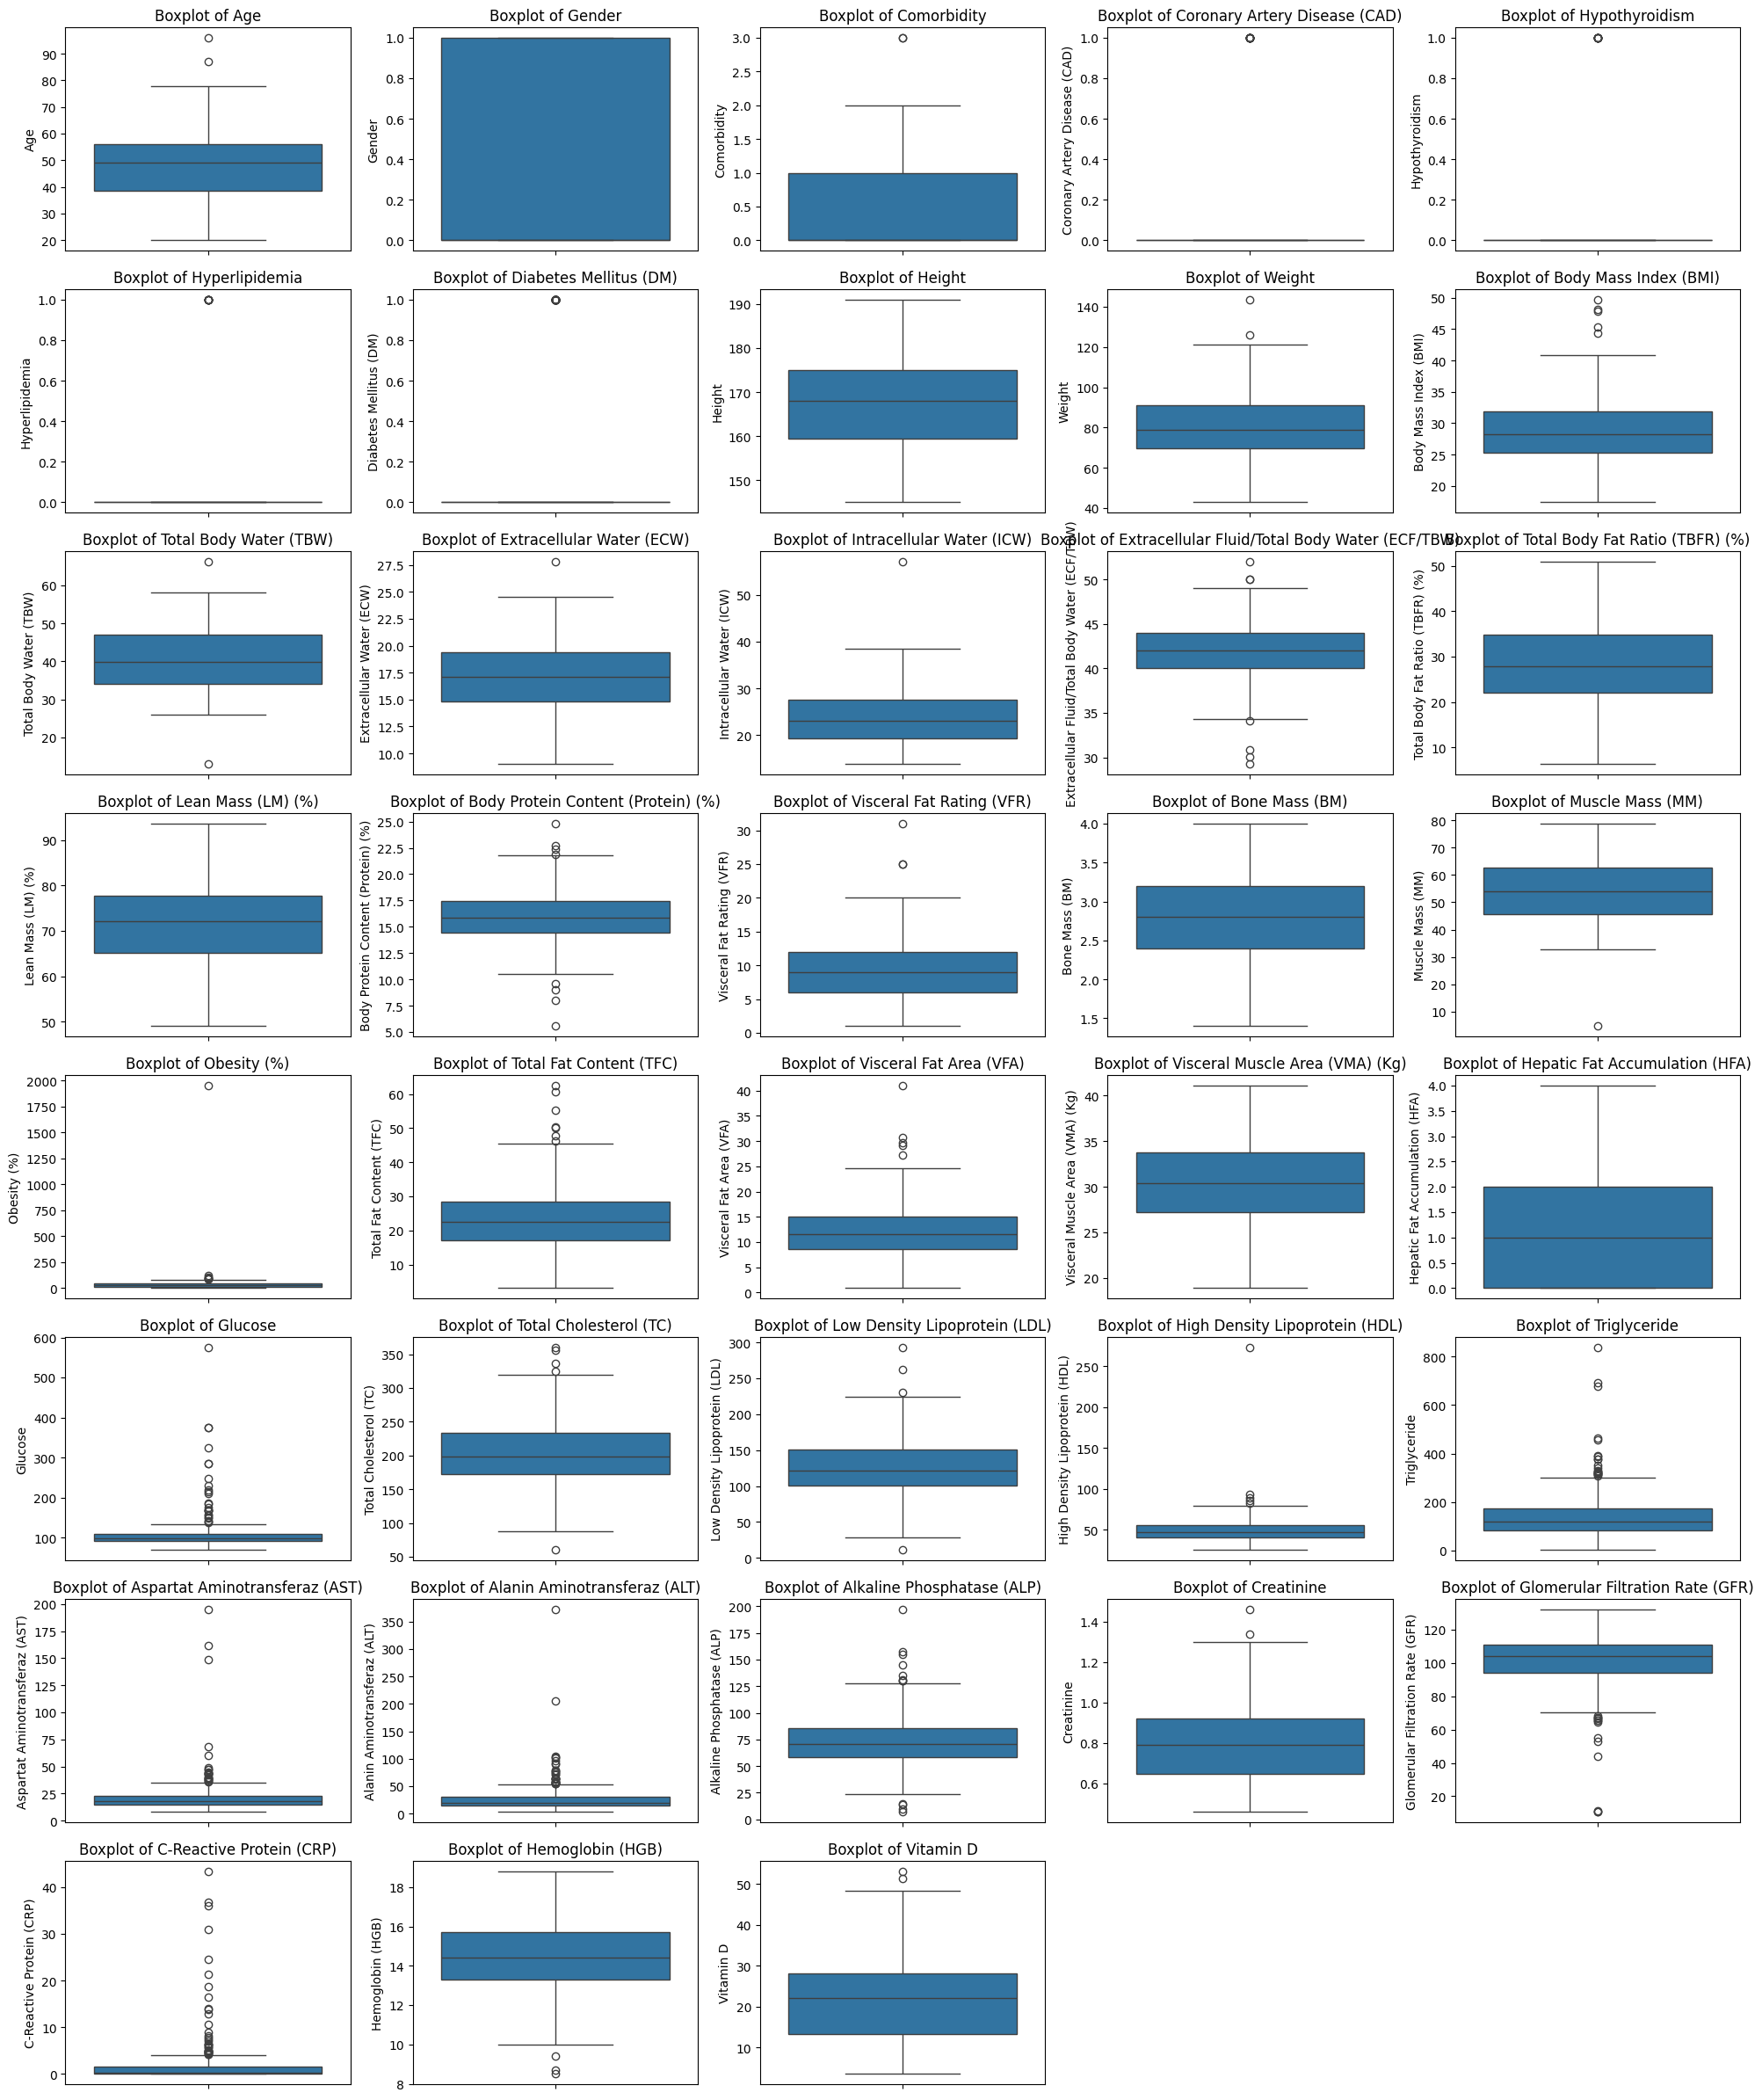

In [296]:
num_plots = len(num_features)
cols = 5  # number of columns you want
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(cols * 4, rows * 3))

for i, col in enumerate(num_features, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

### Step 5: Correlation Heatmap

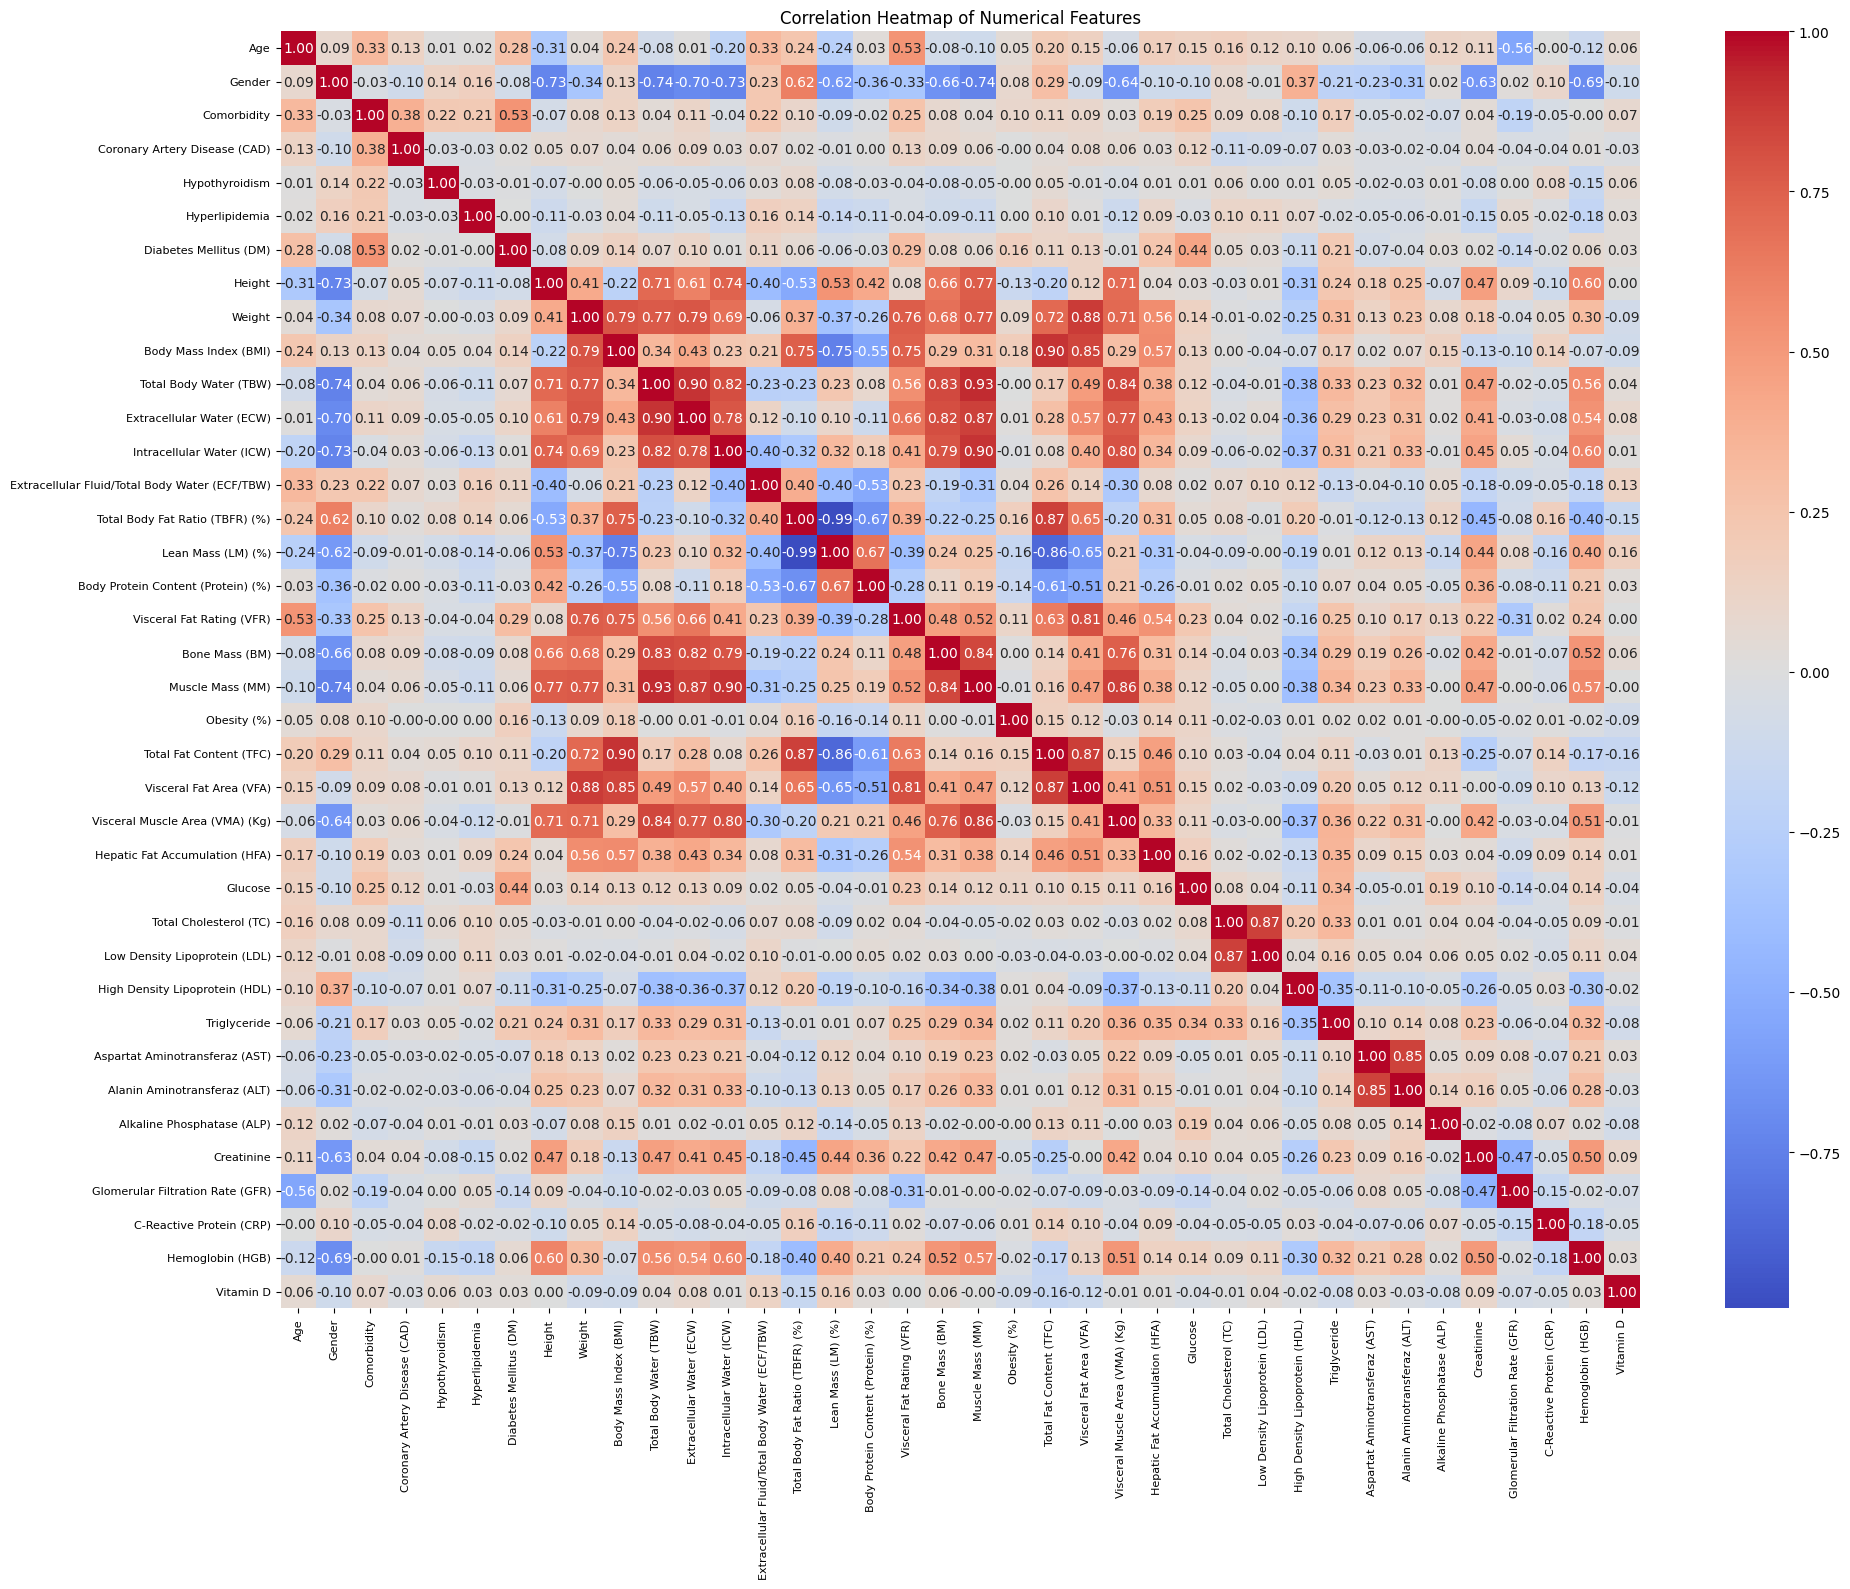

In [301]:
plt.figure(figsize=(20, 16))
corr_matrix = df[num_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()


### Step 6: Class Distribution Analysis 
In this block, the class distribution of the target variable is analyzed to check for class imbalance. Distribution will be analyzed overall and per gender. This will determine if SMOTE will be applied to the training data.


Overall class distribution:
Gallstone Status
0    161
1    158
Name: count, dtype: int64

Overall class distribution (percentage):
Gallstone Status
0    50.470219
1    49.529781
Name: proportion, dtype: float64


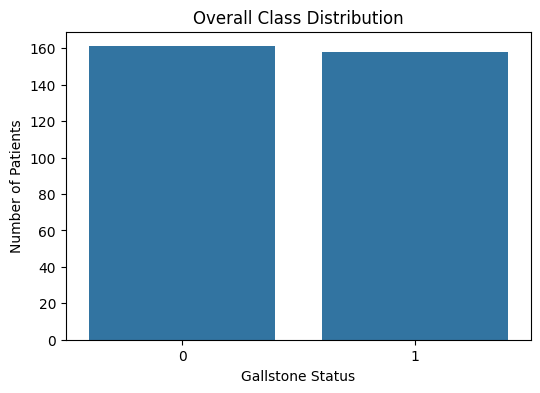

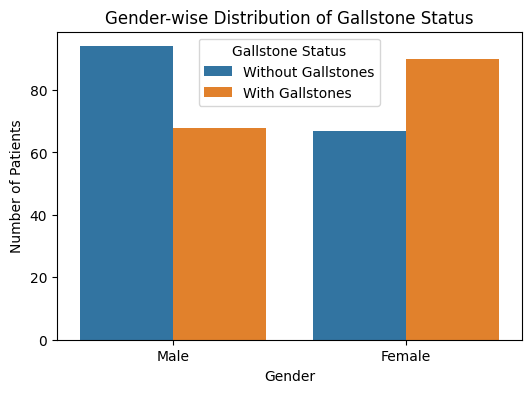

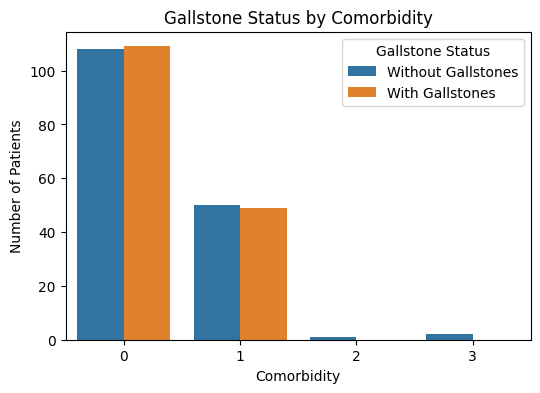

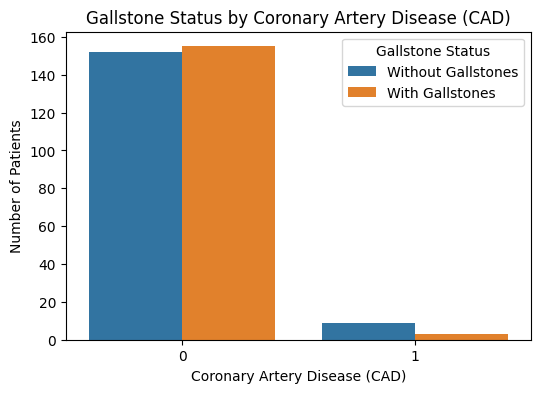

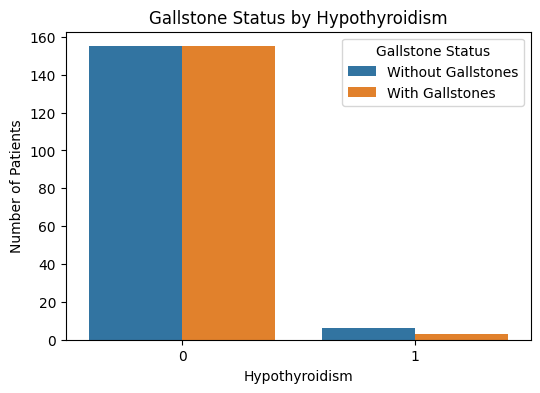

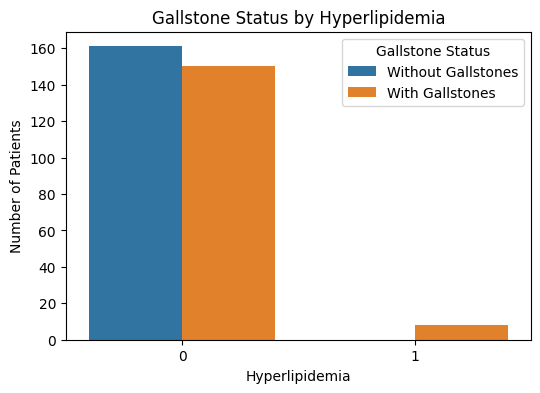

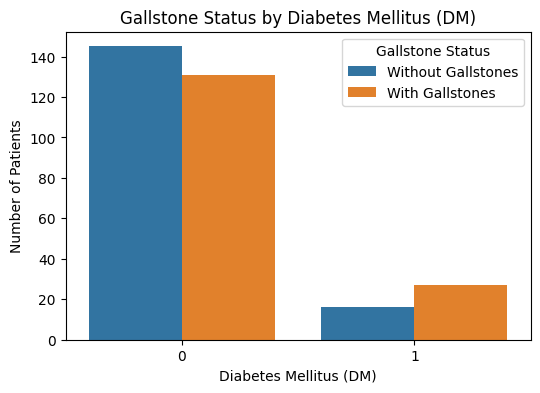

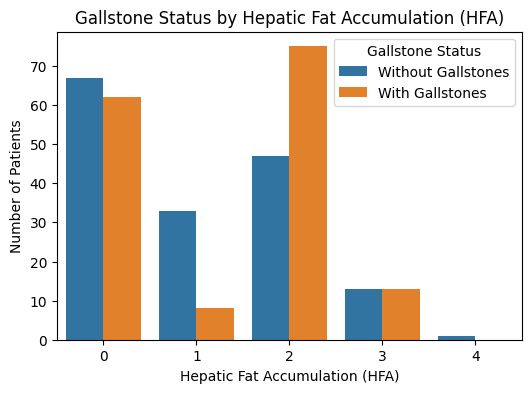

In [302]:
# -------------------------------
# Step 6a: Overall class distribution (Gallstone Status)
print("\nOverall class distribution:")
print(df[target_col].value_counts())
print("\nOverall class distribution (percentage):")
print(df[target_col].value_counts(normalize=True) * 100)

plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df)
plt.title('Overall Class Distribution')
plt.xlabel('Gallstone Status')
plt.ylabel('Number of Patients')
plt.show()

# -------------------------------
# Step 6b: Gender-wise class distribution
plt.figure(figsize=(6,4))
ax = sns.countplot(data=df, x='Gender', hue=target_col)

# Set x-axis tick labels based on your encoding
ax.set_xticks([0, 1])
gender_labels = ['Male', 'Female']
ax.set_xticklabels(gender_labels)

plt.title('Gender-wise Distribution of Gallstone Status')
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.legend(title='Gallstone Status', labels=['Without Gallstones', 'With Gallstones'])
plt.show()

# -------------------------------
# Step 6c: Class distribution per categorical variable (other than gender)
categorical_features = ['Comorbidity', 'Coronary Artery Disease (CAD)', 'Hypothyroidism', 
                        'Hyperlipidemia', 'Diabetes Mellitus (DM)', 'Hepatic Fat Accumulation (HFA)']

for cat in categorical_features:
    plt.figure(figsize=(6,4))
    ax = sns.countplot(data=df, x=cat, hue=target_col)
    plt.title(f'Gallstone Status by {cat}')
    plt.xlabel(cat)
    plt.ylabel('Number of Patients')
    plt.legend(title='Gallstone Status', labels=['Without Gallstones', 'With Gallstones'])
    plt.show()


### Step 3: Data Separation 
Separating the data according to data type to prepare for preprocessing and respective handling measures. Separation permits for more tailored pre-procesisng. 

Remark: 'lab_features' is a list of features pertaining to entries of lab tests. This separation was made based on advice from the instructor.

In [304]:
# -------------------------------
# Step 3: Separate features by type
# Lab test features (blood work and medical tests)
lab_features = ['Glucose', 'Total Cholesterol (TC)', 'Low Density Lipoprotein (LDL)', 'High Density Lipoprotein (HDL)', 
               'Triglyceride', 'Aspartat Aminotransferaz (AST)', 'Alanin Aminotransferaz (ALT)', 
               'Alkaline Phosphatase (ALP)', 'Creatinine', 'Glomerular Filtration Rate (GFR)', 
               'C-Reactive Protein (CRP)', 'Hemoglobin (HGB)', 'Vitamin D']

# Categorical features (binary/discrete variables)
categorical_features = ['Gender', 'Comorbidity', 'Coronary Artery Disease (CAD)', 'Hypothyroidism', 
                       'Hyperlipidemia', 'Diabetes Mellitus (DM)', 'Hepatic Fat Accumulation (HFA)']

# Numerical features (all remaining features that are not categorical or target)
numerical_features = [col for col in df.columns if col not in categorical_features + lab_features + [target_col]]


### Step 4: Pre-processing Pipeline 


In [305]:
# -------------------------------
# Step 4: Preprocessing pipeline
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


### Step 5: Train-Test Split 
The group decided on an 70-30 split (70% training, 30% testing as sourced from a general rule) to ensure a balance between training and testing data. 

Remark: random_state has been set to 42 to ensure reproducibility of results. 

In [306]:
# -------------------------------
# Step 5: Train-test split
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

### Step 6: Pre-Processing Application 


In [307]:
# -------------------------------
# Step 6: Apply preprocessing on train and test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

### Step 7: Feature Selection 
Feature selection will be done via the ANOVA F-value. A threshold approach will be done to ensure statistically interpretable results for feature selection. 

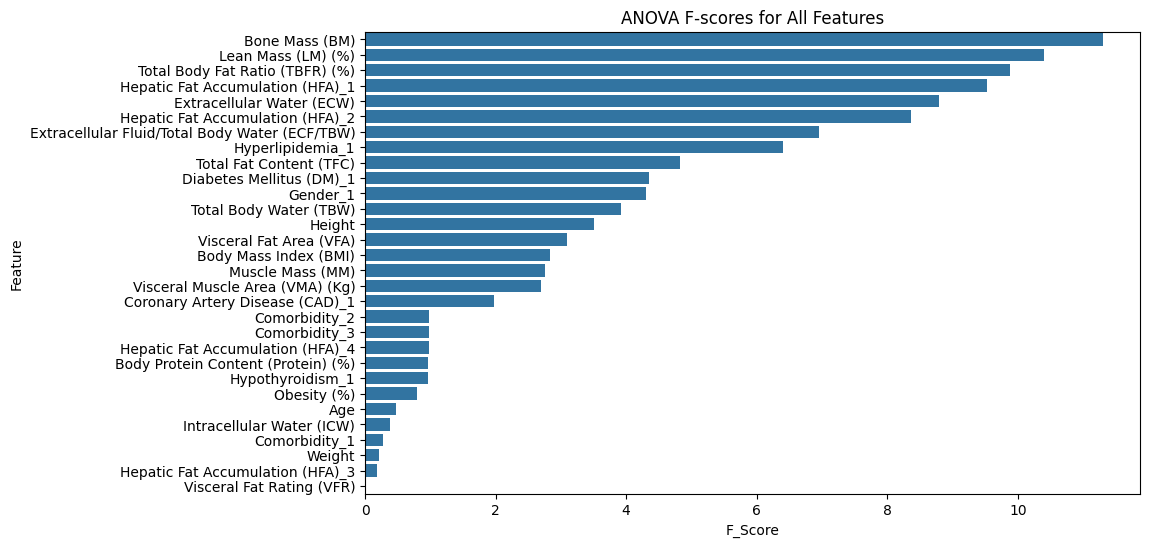

Chosen F-score threshold: 6.005
Number of selected features: 8
Selected features: ['Extracellular Water (ECW)'
 'Extracellular Fluid/Total Body Water (ECF/TBW)'
 'Total Body Fat Ratio (TBFR) (%)' 'Lean Mass (LM) (%)' 'Bone Mass (BM)'
 'Hyperlipidemia_1' 'Hepatic Fat Accumulation (HFA)_1'
 'Hepatic Fat Accumulation (HFA)_2']


In [311]:
# Step 7: Feature selection with ANOVA F-value

# Fit SelectKBest with k='all' to get scores for all features
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train_preprocessed, y_train)

# Extract scores and feature names
f_scores = selector.scores_
feature_names_num = numerical_features
feature_names_cat = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([feature_names_num, feature_names_cat])

# Create dataframe of features and scores
feature_scores_df = pd.DataFrame({'Feature': all_feature_names, 'F_Score': f_scores})

# Visualize the distribution of F-scores
plt.figure(figsize=(10,6))
sns.barplot(x='F_Score', y='Feature', data=feature_scores_df.sort_values(by='F_Score', ascending=False))
plt.title('ANOVA F-scores for All Features')
plt.show()

# Choose threshold based on observed distribution, e.g., 3rd quartile
threshold = feature_scores_df['F_Score'].quantile(0.75)
print(f"Chosen F-score threshold: {threshold:.3f}")

# Select features above threshold
selected_features_mask = f_scores >= threshold
selected_feature_names = all_feature_names[selected_features_mask]

print(f"Number of selected features: {selected_features_mask.sum()}")
print("Selected features:", selected_feature_names)

# Apply feature selection mask to data
X_train_selected = X_train_preprocessed[:, selected_features_mask]
X_test_selected = X_test_preprocessed[:, selected_features_mask]

### Step 8: Cross-Validation Setup

In [312]:
# -------------------------------
# Step 8: Define cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Step 9: Model Training and Evaluation

In [313]:
# -------------------------------
# Step 9: Model training and evaluation loop
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Bagging Classifier': BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42),
}

results = []  # To store results for later export

for model_name, model in models.items():
    print(f"\nCross-validating {model_name}...")
    cross_val_evaluate(model, X_train_selected, y_train, cv)
    # Optional: Train on full training set and evaluate on test set afterwards
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_selected)[:,1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test_selected)
        y_proba = (y_proba - y_proba.min())/(y_proba.max()-y_proba.min())
    else:
        y_proba = None
    print(f"Test set evaluation for {model_name}:")
    evaluate_model(y_test, y_pred, y_proba)

    
    # Collect results for LaTeX export
    results.append({
        "Method": model_name,
        "Precision": round(precision_score(y_test, y_pred), 2),
        "Recall": round(recall_score(y_test, y_pred), 2),
        "F-measure": round(f1_score(y_test, y_pred), 2),
        "AUC": round(roc_auc_score(y_test, y_proba), 2) if y_proba is not None else None
    })



Cross-validating Random Forest...
Mean Accuracy: 0.6941 (+/- 0.0520)
Test set evaluation for Random Forest:
Accuracy: 0.7500
Precision: 0.7857
Recall: 0.6875
F1 Score: 0.7333
ROC AUC: 0.7871

Cross-validating SVM...
Mean Accuracy: 0.6784 (+/- 0.0157)
Test set evaluation for SVM:
Accuracy: 0.7500
Precision: 0.9444
Recall: 0.5312
F1 Score: 0.6800
ROC AUC: 0.8213

Cross-validating Gradient Boosting...
Mean Accuracy: 0.6392 (+/- 0.0319)
Test set evaluation for Gradient Boosting:
Accuracy: 0.7188
Precision: 0.7059
Recall: 0.7500
F1 Score: 0.7273
ROC AUC: 0.8096

Cross-validating Logistic Regression...
Mean Accuracy: 0.6667 (+/- 0.0175)
Test set evaluation for Logistic Regression:
Accuracy: 0.7656
Precision: 0.8148
Recall: 0.6875
F1 Score: 0.7458
ROC AUC: 0.8584

Cross-validating AdaBoost...
Mean Accuracy: 0.6706 (+/- 0.0419)
Test set evaluation for AdaBoost:
Accuracy: 0.6875
Precision: 0.7000
Recall: 0.6562
F1 Score: 0.6774
ROC AUC: 0.7876

Cross-validating Decision Tree...
Mean Accuracy: 